In [13]:
!pip install pmdarima
!pip install tensorflow

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler



In [15]:
btc = pd.read_csv('/content/btc_10yrs.csv')


In [16]:
btc.info()

btc.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      3701 non-null   object
 1   Adj Close  3700 non-null   object
 2   Close      3700 non-null   object
 3   High       3700 non-null   object
 4   Low        3700 non-null   object
 5   Open       3700 non-null   object
 6   Volume     3700 non-null   object
dtypes: object(7)
memory usage: 202.5+ KB


,Price,Adj Close,Close,High,Low,Open,Volume
count,3701,3700,3700,3700,3700,3700,3700
unique,3701,3697,3697,3697,3698,3696,3700
top,2024-11-01 00:00:00+00:00,6741.75,6741.75,244.25100708007812,27375.6015625,17760.30078125,46855045120
freq,1,2,2,2,2,2,1


In [17]:
btc.head(5)

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-17 00:00:00+00:00,457.3340148925781,457.3340148925781,468.17401123046875,452.4219970703125,465.864013671875,21056800
3,2014-09-18 00:00:00+00:00,424.44000244140625,424.44000244140625,456.8599853515625,413.10400390625,456.8599853515625,34483200
4,2014-09-19 00:00:00+00:00,394.7959899902344,394.7959899902344,427.8349914550781,384.5320129394531,424.1029968261719,37919700


In [18]:
btc.isna()

,Price,Adj Close,Close,High,Low,Open,Volume
0,False,False,False,False,False,False,False
1,False,True,True,True,True,True,True
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
3696,False,False,False,False,False,False,False
3697,False,False,False,False,False,False,False
3698,False,False,False,False,False,False,False
3699,False,False,False,False,False,False,False


In [ ]:
btc = btc.iloc[1:]
btc.dropna()
btc.reset_index(drop = True,inplace = True)
btc

In [20]:
btc['profit'] = btc.apply(lambda x: 'Profit' if x['Close']>x['Open'] else 'Loss' ,axis=1)
btc[btc['profit'] == 'Profit']


btc.groupby('profit').count()

#renaming the column name from price to date
btc.rename(columns = {'Price':'Date'}, inplace = True)


#converting the columns to numeric whic is float in this data

btc['Date'] = pd.to_datetime(btc['Date'],errors = 'coerce')
btc['Close'] = btc['Close'].astype('float64')
btc['Open'] = btc['Open'].astype('float64')
btc['High'] = btc['High'].astype('float64')
btc['Low'] = btc['Low'].astype('float64')

btc['dif'] = btc['Close'] - btc['Open']
btc.head(6)
btc['dif'].max()
btc

<ipython-input-20-6d2221f61cdd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['profit'] = btc.apply(lambda x: 'Profit' if x['Close']>x['Open'] else 'Loss' ,axis=1)
<ipython-input-20-6d2221f61cdd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc.rename(columns = {'Price':'Date'}, inplace = True)
<ipython-input-20-6d2221f61cdd>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  btc['Date'] = pd.to_datetime(btc['Date']

,Date,Adj Close,Close,High,Low,Open,Volume,profit,dif
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Loss,NaN
1,2014-09-17 00:00:00+00:00,457.3340148925781,457.334015,468.174011,452.421997,465.864014,21056800,Loss,-8.529999
2,2014-09-18 00:00:00+00:00,424.44000244140625,424.440002,456.859985,413.104004,456.859985,34483200,Loss,-32.419983
3,2014-09-19 00:00:00+00:00,394.7959899902344,394.795990,427.834991,384.532013,424.102997,37919700,Loss,-29.307007
4,2014-09-20 00:00:00+00:00,408.90399169921875,408.903992,423.295990,389.882996,394.673004,36863600,Profit,14.230988
...,...,...,...,...,...,...,...,...,...
3695,2024-10-28 00:00:00+00:00,69907.7578125,69907.757812,70212.265625,67535.132812,67922.671875,38799856657,Profit,1985.085938
3696,2024-10-29 00:00:00+00:00,72720.4921875,72720.492188,73577.210938,69729.914062,69910.046875,58541874402,Profit,2810.445312
3697,2024-10-30 00:00:00+00:00,72339.5390625,72339.539062,72905.296875,71411.734375,72715.367188,40646637831,Loss,-375.828125
3698,2024-10-31 00:00:00+00:00,70215.1875,70215.187500,72662.312500,69590.500000,72335.046875,40627912076,Loss,-2119.859375


need to standardize the data to do this

In [21]:
# Assuming `btc` is your DataFrame and 'diff' is the column to process
scaler = StandardScaler()

# Standardize the 'diff' column
btc['Standardized_diff'] = scaler.fit_transform(btc[['dif']])

# Define bins and labels
bins = [-np.inf, -1.5, -0.5, 0.5, 1.5, np.inf]  # Adjust these values to reflect standardized data
labels = ['low Return', 'Below Avg Return', 'Avg Return', 'Abv Avg Return', 'High Return']

# Apply binning on the standardized 'diff'
btc['Count Category'] = pd.cut(btc['Standardized_diff'], bins, labels=labels)

# Group by Count Category and count
grouped_counts = btc.groupby('Count Category',observed = True).count()

# Display the results
print(grouped_counts.to_string(), end = "")

                  Date  Adj Close  Close  High   Low  Open  Volume  profit   dif  Standardized_diff
Count Category                                                                                     
low Return         170        170    170   170   170   170     170     170   170                170
Below Avg Return   297        297    297   297   297   297     297     297   297                297
Avg Return        2735       2735   2735  2735  2735  2735    2735    2735  2735               2735
Abv Avg Return     321        321    321   321   321   321     321     321   321                321
High Return        176        176    176   176   176   176     176     176   176                176

In [22]:
btc

,Date,Adj Close,Close,High,Low,Open,Volume,profit,dif,Standardized_diff,Count Category
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Loss,NaN,NaN,NaN
1,2014-09-17 00:00:00+00:00,457.3340148925781,457.334015,468.174011,452.421997,465.864014,21056800,Loss,-8.529999,-0.029274,Avg Return
2,2014-09-18 00:00:00+00:00,424.44000244140625,424.440002,456.859985,413.104004,456.859985,34483200,Loss,-32.419983,-0.056018,Avg Return
3,2014-09-19 00:00:00+00:00,394.7959899902344,394.795990,427.834991,384.532013,424.102997,37919700,Loss,-29.307007,-0.052533,Avg Return
4,2014-09-20 00:00:00+00:00,408.90399169921875,408.903992,423.295990,389.882996,394.673004,36863600,Profit,14.230988,-0.003795,Avg Return
...,...,...,...,...,...,...,...,...,...,...,...
3695,2024-10-28 00:00:00+00:00,69907.7578125,69907.757812,70212.265625,67535.132812,67922.671875,38799856657,Profit,1985.085938,2.202453,High Return
3696,2024-10-29 00:00:00+00:00,72720.4921875,72720.492188,73577.210938,69729.914062,69910.046875,58541874402,Profit,2810.445312,3.126391,High Return
3697,2024-10-30 00:00:00+00:00,72339.5390625,72339.539062,72905.296875,71411.734375,72715.367188,40646637831,Loss,-375.828125,-0.440442,Avg Return
3698,2024-10-31 00:00:00+00:00,70215.1875,70215.187500,72662.312500,69590.500000,72335.046875,40627912076,Loss,-2119.859375,-2.392775,low Return


In [23]:
btc.dtypes

,0
Date,"datetime64[ns, UTC]"
Adj Close,object
Close,float64
High,float64
Low,float64
Open,float64
Volume,object
profit,object
dif,float64
Standardized_diff,float64


In [24]:
#model

In [25]:
# Filter for dates between 2015 and 2020
btc5yrs = btc[(btc['Date'] >= '2015-01-01') & (btc['Date'] < '2020-01-01')]
btc5yrs.reset_index(drop = True,inplace = True)
btc5yrs.head()

,Date,Adj Close,Close,High,Low,Open,Volume,profit,dif,Standardized_diff,Count Category
0,2015-01-01 00:00:00+00:00,314.2489929199219,314.248993,320.434998,314.002991,320.434998,8036550,Loss,-6.186005,-0.026650,Avg Return
1,2015-01-02 00:00:00+00:00,315.0320129394531,315.032013,315.838989,313.565002,314.079010,7860650,Profit,0.953003,-0.018659,Avg Return
2,2015-01-03 00:00:00+00:00,281.0820007324219,281.082001,315.149994,281.082001,314.846008,33054400,Loss,-33.764008,-0.057522,Avg Return
3,2015-01-04 00:00:00+00:00,264.19500732421875,264.195007,287.230011,257.612000,281.145996,55629100,Loss,-16.950989,-0.038701,Avg Return
4,2015-01-05 00:00:00+00:00,274.4739990234375,274.473999,278.341003,265.084015,265.084015,43962800,Profit,9.389984,-0.009214,Avg Return


In [26]:
btc_forecast = btc5yrs[['Date','Close']]
btc_forecast.reset_index(drop = True,inplace = True)
btc_forecast.head(5)

,Date,Close
0,2015-01-01 00:00:00+00:00,314.248993
1,2015-01-02 00:00:00+00:00,315.032013
2,2015-01-03 00:00:00+00:00,281.082001
3,2015-01-04 00:00:00+00:00,264.195007
4,2015-01-05 00:00:00+00:00,274.473999


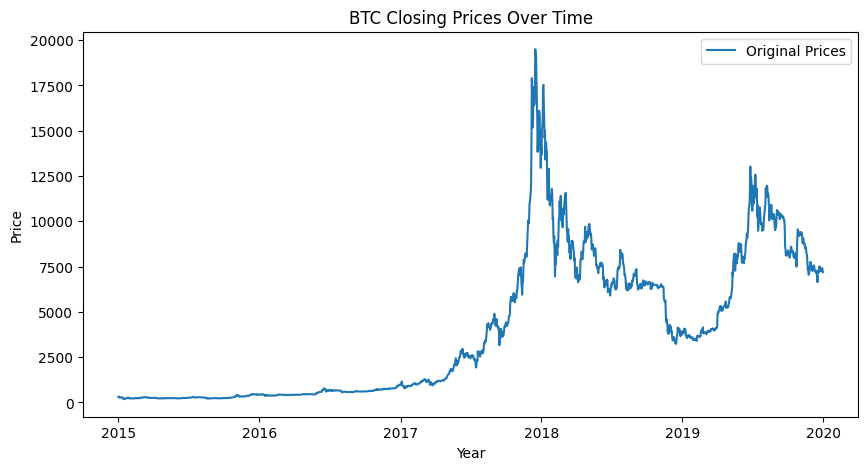

In [27]:
# Plot the original time series
plt.figure(figsize=(10, 5))
plt.plot(btc_forecast['Date'],btc_forecast['Close'], label='Original Prices')
plt.title('BTC Closing Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

check for stationary of time series


<Figure size 1200x600 with 0 Axes>

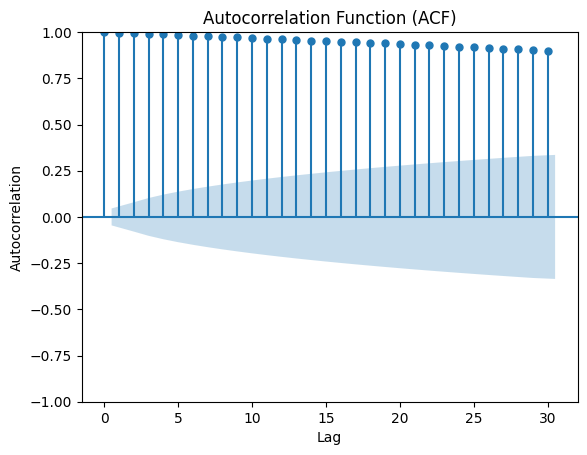

<Figure size 1200x600 with 0 Axes>

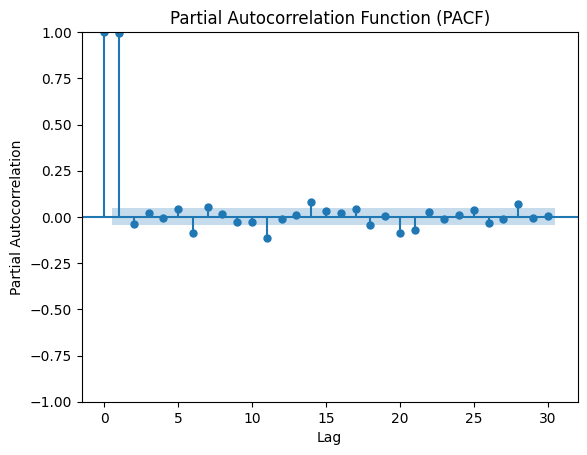

In [28]:
#plotting ACF and PACF after transforming
# 1. Plot the ACF
plt.figure(figsize=(12, 6))
plot_acf(btc_forecast['Close'], lags=30, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# 2. Plot the PACF
plt.figure(figsize=(12, 6))
plot_pacf(btc_forecast['Close'], lags=30, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

Transforming the data to stationary by differencing

In [44]:
# Create a copy of the DataFrame to avoid chained assignment
btc_forecast = btc_forecast.copy()
btc_forecast['log_diff'] = np.log(btc_forecast['Close'])
btc_forecast['diff'] = btc_forecast['log_diff'].diff().dropna()
btc_forecast.dropna(inplace = True)
btc_forecast.reset_index(drop = True,inplace = True)
btc_forecast


,Date,Close,log_close,diff,log_diff
0,2015-01-03 00:00:00+00:00,281.082001,5.638646,-0.114028,5.638646
1,2015-01-04 00:00:00+00:00,264.195007,5.576687,-0.061959,5.576687
2,2015-01-05 00:00:00+00:00,274.473999,5.614857,0.038169,5.614857
3,2015-01-06 00:00:00+00:00,286.188995,5.656652,0.041796,5.656652
4,2015-01-07 00:00:00+00:00,294.337006,5.684725,0.028073,5.684725
...,...,...,...,...,...
1819,2019-12-27 00:00:00+00:00,7290.088379,8.894271,0.007037,8.894271
1820,2019-12-28 00:00:00+00:00,7317.990234,8.898091,0.003820,8.898091
1821,2019-12-29 00:00:00+00:00,7422.652832,8.912292,0.014201,8.912292
1822,2019-12-30 00:00:00+00:00,7292.995117,8.894670,-0.017622,8.894670


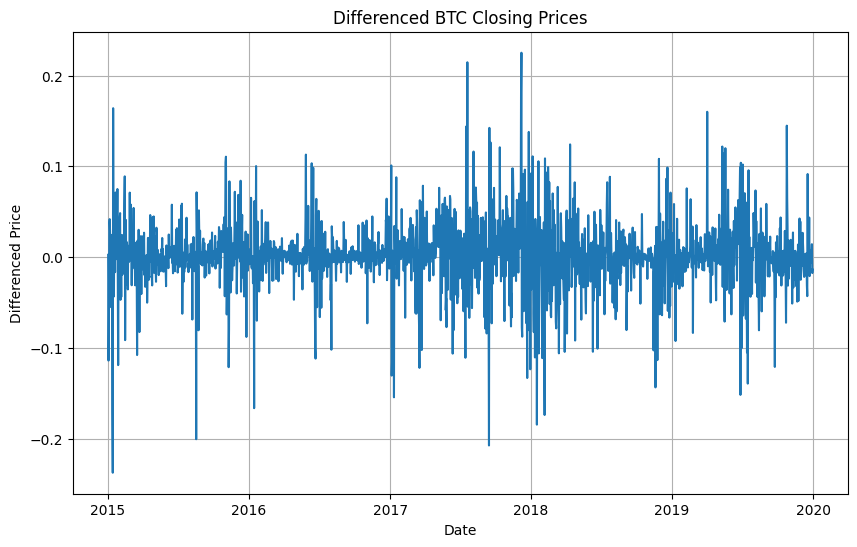

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(btc_forecast['Date'], btc_forecast['diff'])
plt.title('Differenced BTC Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

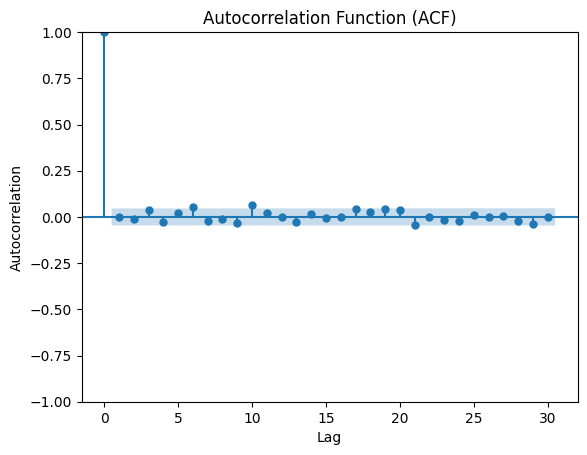

<Figure size 1200x600 with 0 Axes>

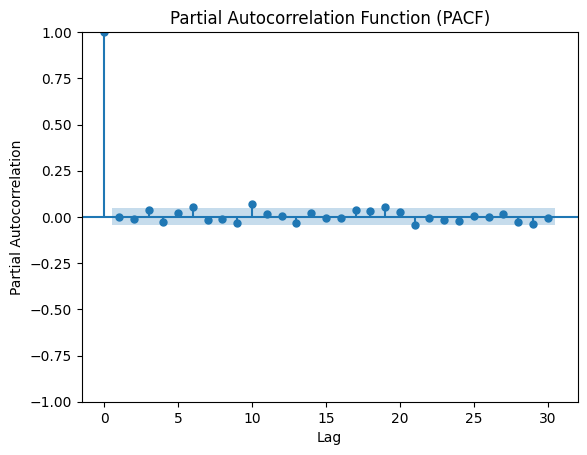

In [30]:
#plotting ACF and PACF after transforming
# 1. Plot the ACF
plt.figure(figsize=(12, 6))
plot_acf(btc_forecast['diff'], lags=30, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# 2. Plot the PACF
plt.figure(figsize=(12, 6))
plot_pacf(btc_forecast['diff'], lags=30, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [31]:

# Augmented Dickey-Fuller Test for Stationarity
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Test for {title}')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print("Conclusion: The data is stationary.")
    else:
        print("Conclusion: The data is not stationary.")

# Run the ADF test on original and differenced series
adf_test(btc_forecast['Close'], title='Original Closing Prices')
adf_test(btc_forecast['diff'], title='Differenced Closing Prices')

ADF Test for Original Closing Prices
ADF Statistic: -1.8547098482998285
p-value: 0.35365754414919903
Critical Values:
   1%: -3.4339800605797155
   5%: -2.8631434696839992
   10%: -2.5676236347535166
Conclusion: The data is not stationary.
ADF Test for Differenced Closing Prices
ADF Statistic: -42.64848360231461
p-value: 0.0
Critical Values:
   1%: -3.433940201056092
   5%: -2.8631258735235106
   10%: -2.5676142653629
Conclusion: The data is stationary.


In [49]:
# Undoing the log transformation before model fitting
#btc_forecast['undiff_log_close'] = btc_forecast['log_diff'].cumsum()  # Reverse differencing of log_diff column
#btc_forecast['original_close'] = np.exp(btc_forecast['undiff_log_close']) # Exponentiating to reverse the log transform


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [52]:
np.random.seed(42)
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
max_p = 4
max_d = 1
max_q = 4
def find_best_aic_model(data, max_p, max_d, max_q):
    best_aic = np.inf
    best_model = None
    best_order = None
    for p, d, q in product(range(max_p + 1), range(max_d + 1), range(max_q + 1)):
        try:
            model = SARIMAX(data, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_model = model_fit
                best_order = (p, d, q)
        except Exception as e:
            continue
    return best_order, best_aic

best_order, best_aic = find_best_aic_model(btc_forecast['diff'], max_p, max_d, max_q)
print("Best Order:", best_order)
print("Best AIC:", best_aic)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best Order: (2, 0, 2)
Best AIC: -6673.2477986253525


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                 1824
Model:                 ARIMA(2, 0, 2)   Log Likelihood                3335.727
Date:                Fri, 27 Dec 2024   AIC                          -6659.455
Time:                        16:20:48   BIC                          -6626.402
Sample:                             0   HQIC                         -6647.262
                               - 1824                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.877      0.061   -7.58e-05       0.003
ar.L1          0.0004      1.343      0.000      1.000      -2.632       2.633
ar.L2         -0.0072      1.285     -0.006      0.9

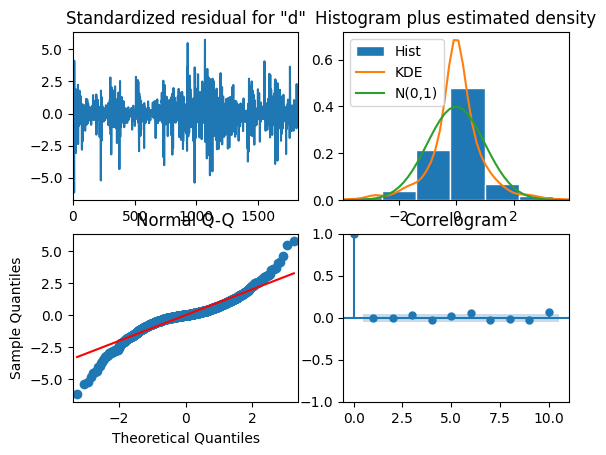

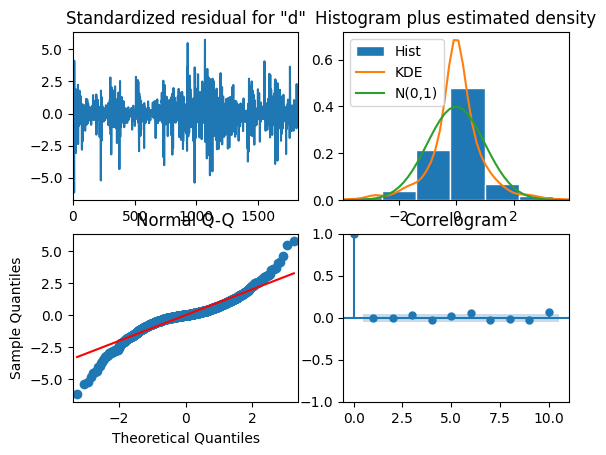

In [53]:
# Defining an ARMA model
best_model = ARIMA(btc_forecast['diff'], order=best_order)
best_results = best_model.fit()
print(best_results.summary())
best_results.plot_diagnostics()

Train Size: 1459, Test Size: 365


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


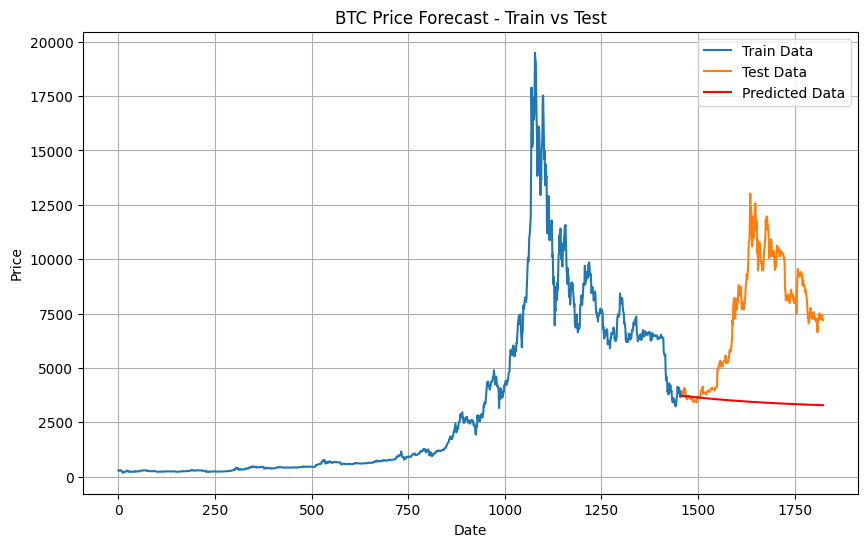

Mean Squared Error: 22950806.203626577
Root Mean Squared Error: 4790.699970111526


In [54]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assume btc_forecast contains 5 years of data with 'Close' as the target column
# Split the data into train (80%) and test (20%)
# 4. Train-Test Split
train_size = int(len(btc_forecast) * 0.8)
train_data = btc_forecast['Close'][:train_size]
test_data = btc_forecast['Close'][train_size:]
# Print the sizes of the train and test datasets
print(f"Train Size: {len(train_data)}, Test Size: {len(test_data)}")

# Fit ARIMA model on the training dataset
model = ARIMA(train_data, order=best_order)  # Adjust (p, d, q) based on previous analysis
model_fit = model.fit()

# Forecast for the test period
forecast = model_fit.forecast(steps=len(test_data))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label="Train Data") # Access Close column from train_data DataFrame
plt.plot(test_data.index, test_data, label="Test Data")  # Access Close column from test_data DataFrame
plt.plot(test_data.index, forecast, label="Predicted Data", color='red')
plt.title("BTC Price Forecast - Train vs Test")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Evaluate the model performance
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(test_data, forecast) # Access Close column from test_data DataFrame
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


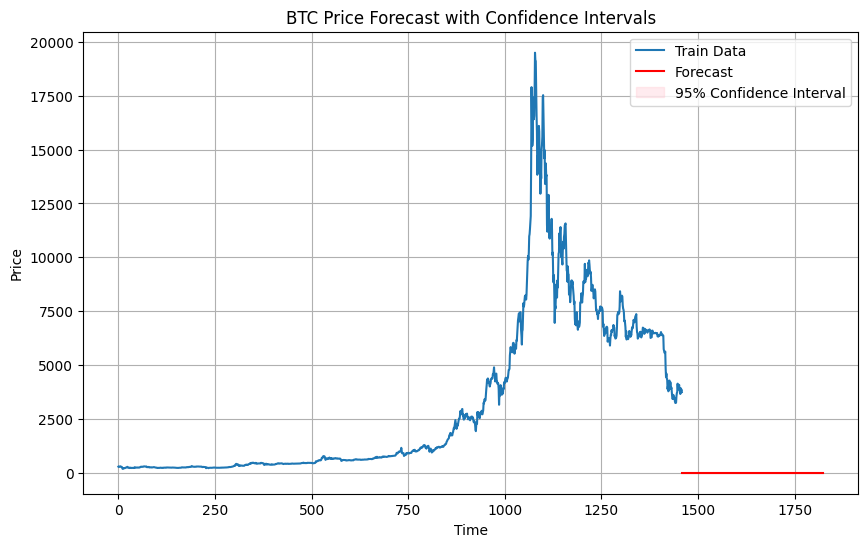

In [55]:
# Assuming best_results is an ARIMA model result
forecast = best_results.forecast(steps=len(test_data), alpha=0.05)  # 95% confidence level

# Get confidence intervals separately
conf_int = best_results.get_forecast(steps=len(test_data)).conf_int(alpha=0.05)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label="Train Data")
plt.plot(test_data.index, forecast, label="Forecast", color='red')

# Add confidence intervals to the plot
# Access confidence intervals using .iloc[] for integer-based indexing
lower_conf = conf_int.iloc[:, 0]  # Lower bound
upper_conf = conf_int.iloc[:, 1]  # Upper bound

plt.fill_between(
    test_data.index,
    lower_conf, upper_conf,
    color='pink', alpha=0.3, label="95% Confidence Interval"
)

plt.title("BTC Price Forecast with Confidence Intervals")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

In [37]:
# Extracting the series
data_series = btc_forecast['Close'].values.reshape(-1, 1)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data_series.reshape(-1, 1))

# Split the data into training and testing sets
tr_size = int(len(data_normalized) * 0.67)
test_size = len(data_normalized) - tr_size
train, test = data_normalized[0:tr_size],\
data_normalized[tr_size:len(data_normalized)]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()


# Traing the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


# Make predictions
tr_predict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
tr_predict = scaler.inverse_transform(tr_predict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate and print RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], tr_predict[:,0]))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print(f'Test Score: {testScore:.2f} RMSE')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1220/1220 - 5s - 4ms/step - loss: 0.0302
Epoch 2/100
1220/1220 - 3s - 2ms/step - loss: 0.0034
Epoch 3/100
1220/1220 - 5s - 4ms/step - loss: 2.5179e-04
Epoch 4/100
1220/1220 - 3s - 2ms/step - loss: 2.5889e-04
Epoch 5/100
1220/1220 - 5s - 4ms/step - loss: 2.5868e-04
Epoch 6/100
1220/1220 - 4s - 3ms/step - loss: 2.6677e-04
Epoch 7/100
1220/1220 - 3s - 2ms/step - loss: 2.5311e-04
Epoch 8/100
1220/1220 - 3s - 2ms/step - loss: 2.5403e-04
Epoch 9/100
1220/1220 - 3s - 3ms/step - loss: 2.5914e-04
Epoch 10/100
1220/1220 - 4s - 3ms/step - loss: 2.5799e-04
Epoch 11/100
1220/1220 - 4s - 4ms/step - loss: 2.6120e-04
Epoch 12/100
1220/1220 - 3s - 2ms/step - loss: 2.5629e-04
Epoch 13/100
1220/1220 - 6s - 5ms/step - loss: 2.4898e-04
Epoch 14/100
1220/1220 - 3s - 2ms/step - loss: 2.5389e-04
Epoch 15/100
1220/1220 - 3s - 2ms/step - loss: 2.4883e-04
Epoch 16/100
1220/1220 - 6s - 5ms/step - loss: 2.4935e-04
Epoch 17/100
1220/1220 - 3s - 2ms/step - loss: 2.6518e-04
Epoch 18/100
1220/1220 - 5s - 4

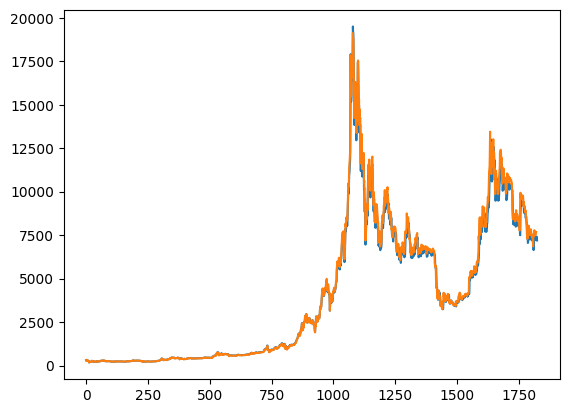

In [38]:
# Plot original vs predictions
plt.plot(scaler.inverse_transform(data_normalized))
plt.plot(np.concatenate([tr_predict, testPredict]))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<ipython-input-39-b6a54fc85aee>:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=btc_forecast['Date'].iloc[-1], periods=future_steps + 1, freq='M')[1:] # Use btc_forecast['Date'] for date range


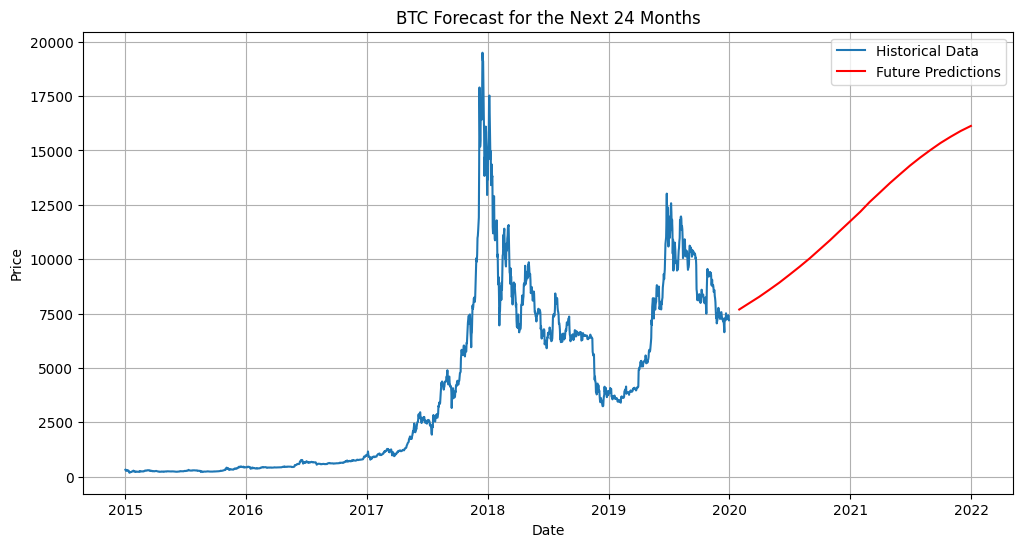

In [39]:
# Number of future months to predict
future_steps = 24

# Initialize array for storing future predictions
future_predictions = np.empty((future_steps, 1))

# Start with the last time step from your test set
current_step = testX[-1, :, :]  # Use the last time step from your test data

for i in range(future_steps):
    # Reshape input data for the model (samples, time steps, features)
    current_step_reshaped = np.reshape(current_step, (1, current_step.shape[0], 1))  # Shape: (1, look_back, 1)
    # Predict the next step
    next_step = model.predict(current_step_reshaped)
    # Store the prediction
    future_predictions[i] = next_step
    # Update the current step by appending the predicted value and removing the oldest value
    current_step = np.append(current_step[1:], next_step).reshape(-1, 1)

# Transform predictions back to the original scale
future_predictions = scaler.inverse_transform(future_predictions)

# Plot the predictions
plt.figure(figsize=(12, 6))
# Replace scaled_data with data_normalized
plt.plot(btc_forecast['Date'], scaler.inverse_transform(data_normalized), label='Historical Data')  # Historical BTC data
future_dates = pd.date_range(start=btc_forecast['Date'].iloc[-1], periods=future_steps + 1, freq='M')[1:] # Use btc_forecast['Date'] for date range
plt.plot(future_dates, future_predictions, label='Future Predictions', color='red')
plt.legend()
plt.title('BTC Forecast for the Next 24 Months')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

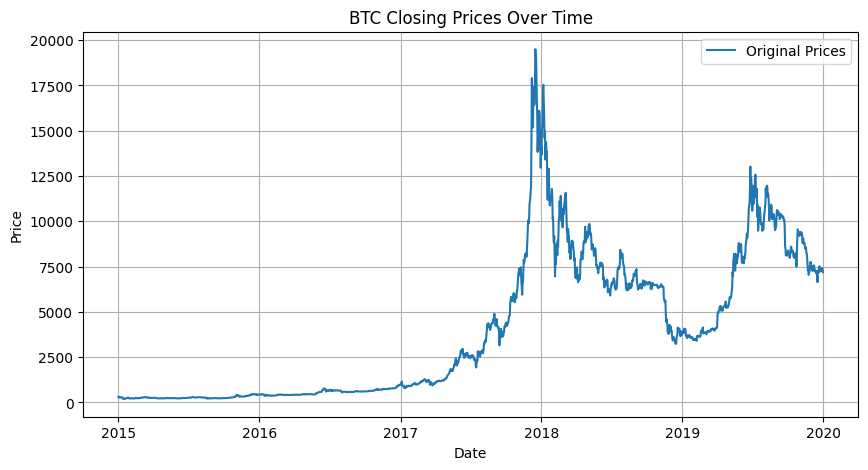

<ipython-input-40-5316cf532da1>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_forecast['log_close'] = np.log(btc_forecast['Close'])
<ipython-input-40-5316cf532da1>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_forecast['diff'] = btc_forecast['log_close'].diff().dropna()
<ipython-input-40-5316cf532da1>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

ADF Test for Original Closing Prices
ADF Statistic: -1.8547098482998285
p-value: 0.35365754414919903
Critical Values:
   1%: -3.4339800605797155
   5%: -2.8631434696839992
   10%: -2.5676236347535166
Conclusion: The data is not stationary.
ADF Test for Differenced Log Prices
ADF Statistic: -42.64848360231461
p-value: 0.0
Critical Values:
   1%: -3.433940201056092
   5%: -2.8631258735235106
   10%: -2.5676142653629
Conclusion: The data is stationary.


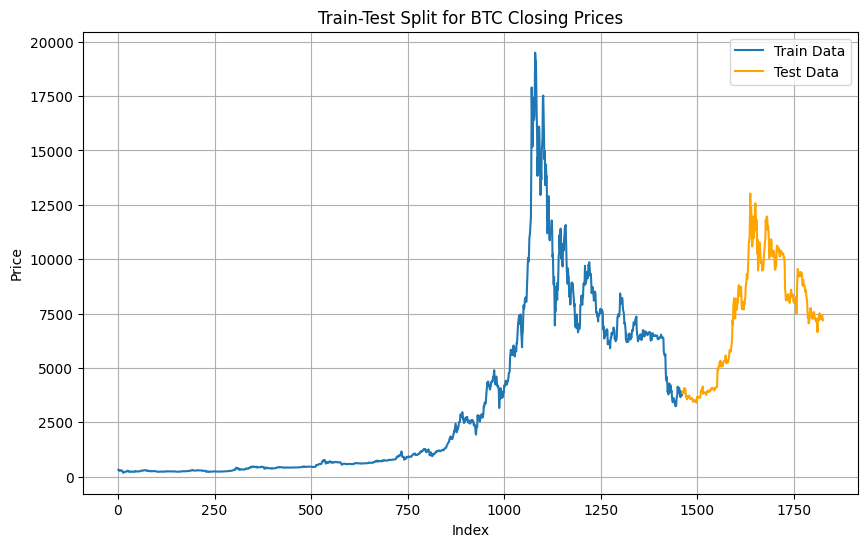

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

KeyboardInterrupt: 

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Set seed for reproducibility
np.random.seed(42)

# Assume btc_forecast contains the data with 'Date' and 'Close' columns
btc_forecast = btc5yrs[['Date', 'Close']]
btc_forecast.reset_index(drop=True, inplace=True)

# 1. Plot Original Time Series
plt.figure(figsize=(10, 5))
plt.plot(btc_forecast['Date'], btc_forecast['Close'], label='Original Prices')
plt.title('BTC Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# 2. Log Transformation and Differencing
btc_forecast['log_close'] = np.log(btc_forecast['Close'])
btc_forecast['diff'] = btc_forecast['log_close'].diff().dropna()
btc_forecast.dropna(inplace=True)

# 3. ADF Test for Stationarity
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Test for {title}')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print("Conclusion: The data is stationary.")
    else:
        print("Conclusion: The data is not stationary.")

adf_test(btc_forecast['Close'], title='Original Closing Prices')
adf_test(btc_forecast['diff'], title='Differenced Log Prices')

# 4. Train-Test Split
train_size = int(len(btc_forecast) * 0.8)
train_data = btc_forecast['Close'][:train_size]
test_data = btc_forecast['Close'][train_size:]

# 5. Plot Train-Test Split
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.title('Train-Test Split for BTC Closing Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Find Best ARIMA Order (p, d, q)
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

max_p = 8
max_d = 2
max_q = 8

def find_best_aic_model(data, max_p, max_d, max_q):
    best_aic = np.inf
    best_model = None
    best_order = None
    for p, d, q in product(range(max_p + 1), range(max_d + 1), range(max_q + 1)):
        try:
            model = SARIMAX(data, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_model = model_fit
                best_order = (p, d, q)
        except Exception as e:
            continue
    return best_order, best_aic

best_order, best_aic = find_best_aic_model(btc_forecast['diff'], max_p, max_d, max_q)
print("Best Order:", best_order)
print("Best AIC:", best_aic)

# Fit ARIMA Model
model = ARIMA(train_data, order=best_order)  # Replace best_order with the identified (p, d, q)
model_fit = model.fit()

# Forecast for the Test Data
forecast = model_fit.forecast(steps=len(test_data))

# Plot the Forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label="Train Data")
plt.plot(test_data.index, test_data, label="Test Data")
plt.plot(test_data.index, forecast, label="Predicted Data", color='red')
plt.title("BTC Price Forecast - Train vs Test")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Evaluate the Model
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot Forecast with Confidence Intervals
forecast_conf = model_fit.get_forecast(steps=len(test_data))
conf_int = forecast_conf.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label="Train Data")
plt.plot(test_data.index, test_data, label="Test Data")
plt.plot(test_data.index, forecast, label="Forecast", color='red')
plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label="95% Confidence Interval")
plt.title("BTC Price Forecast with Confidence Intervals")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()
